###### From SAV to LOVE

# HW2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [2]:
data = pd.read_csv('../data/retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [4]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(10)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8..."
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884..."
7,14,"[840601, 867293, 933067, 951590, 952408, 96569..."
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 13..."
9,16,"[1062973, 1082185, 13007710]"


In [5]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""   
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [6]:
%%time
items = data_train.item_id.unique()
result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))
result.head(2)

CPU times: user 15.6 s, sys: 14.5 ms, total: 15.6 s
Wall time: 18.4 s


,user_id,actual,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[15629852, 1082211, 989763, 887521, 9836775]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[9673970, 5585031, 1017318, 1040194, 1172420]"


### Задание №1. Weighted Random Recommendation

#### Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

__numpy.random.choice(a, size=None, replace=True, p=None)__ 
* __p__ - одномерный массив или одномерная последовательность, необязательный параметр
    Каждый элемент массива p определяет вероятность соответствующего элемнта из a оказаться в выборке. Входной массив a и p должны быть одинаковой длинны, а сумма элементов массива p должна быть равна 1. По умолчанию p = None, что соответствует равномерному распределению вероятности.

In [31]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    items = np.array(items_weights['item_id'])
    recs = np.random.choice(items, size=n, replace=False, p=items_weights['weight'])
    
    return recs.tolist()

Для того, чтобы функция логарифма от продаж не приминала значение -inf или <=0, к сумме продаж по товару буду прибавлять 1.1

In [11]:
np.log(1.1)

0.09531017980432493

Сделайте предсказания

In [21]:
%%time
popular = data_train.groupby('item_id')['sales_value'].sum().reset_index()
popular.head()

CPU times: user 283 ms, sys: 31 ms, total: 314 ms
Wall time: 639 ms


,item_id,sales_value
0,25671,20.94
1,26081,0.99
2,26093,1.59
3,26190,1.54
4,26355,1.98


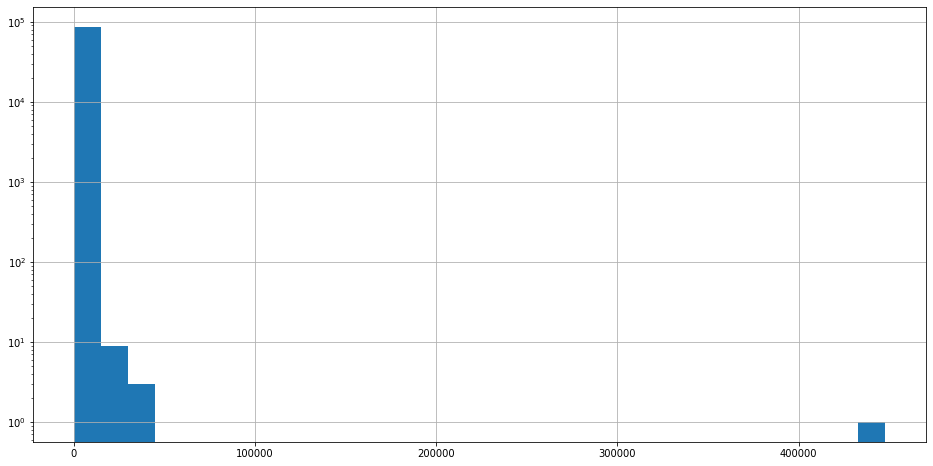

In [22]:
plt.figure(figsize=(16, 8))
popular['sales_value'].hist(bins=30)
plt.yscale(value="log")
plt.show()

In [23]:
#у нас есть один выброс - подкорректируем значение выброса
popular.loc[popular['sales_value']>50000,'sales_value'] = 44779.99
popular['sales_value_log'] = np.log(popular['sales_value']+1.1)
total = np.sum(popular['sales_value_log'])
popular['weight'] = popular['sales_value_log'] / total
popular.head()

,item_id,sales_value,sales_value_log,weight
0,25671,20.94,3.092859,0.000013
1,26081,0.99,0.737164,0.000003
2,26093,1.59,0.989541,0.000004
3,26190,1.54,0.970779,0.000004
4,26355,1.98,1.124930,0.000005


In [24]:
total

242439.82904702285

In [25]:
#Проверим, что сумма всех весов равна единице
sum_weight = np.sum(popular['weight'])
sum_weight

0.9999999999999999

In [69]:
len(popular)

86865

In [32]:
%%time
popular['weighted_random_recommendation'] = popular['item_id'].apply(lambda x: weighted_random_recommendation(popular[['item_id','weight']], n=5))
result.head(2)

CPU times: user 11min 59s, sys: 2.48 s, total: 12min 1s
Wall time: 17min 31s


,user_id,actual,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[15629852, 1082211, 989763, 887521, 9836775]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[9673970, 5585031, 1017318, 1040194, 1172420]"


### Задание №2. Расчет метрик
#### Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [64]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    #print(flags)
    
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [45]:
import pickle
result = pickle.load(open('../predictions/predictions_basic.p','rb'))
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[924247, 1053628, 1068708, 13039855, 15972523]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1104150, 1019389, 1124820, 404120, 1186767]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [65]:
result.apply(lambda row: precision_at_k(row['random_recommendation'], list(row['actual'])), axis=1).mean()

0.00039177277179236047

In [66]:
result.apply(lambda row: precision_at_k(row['popular_recommendation'], list(row['actual'])), axis=1).mean()

0.15523996082272282

In [67]:
result.apply(lambda row: precision_at_k(row['itemitem'], list(row['actual'])), axis=1).mean()

0.13692458374143

In [68]:
result.apply(lambda row: precision_at_k(row['cosine'], list(row['actual'])), axis=1).mean()

0.1329089128305583

In [69]:
result.apply(lambda row: precision_at_k(row['tfidf'], list(row['actual'])), axis=1).mean()

0.13898139079333988

In [70]:
result.apply(lambda row: precision_at_k(row['own_purchases'], list(row['actual'])), axis=1).mean()

0.17969311132876264

#### Best качество показывает алгоритм own_purchases и наменьшее наш рандом